
# Fast Poison-Point Finder — **Final**

This single notebook contains **all code** to:
1. Setup & imports (CPU-friendly).
2. Create **poisoned indices** for CIFAR-10.
3. **Train** clean and poisoned ResNet-18 models.
4. **Evaluate** clean accuracy and **attack success rate (ASR)**.
5. **Embed** the CIFAR-10 training set with a **frozen ResNet-18 (ImageNet)**.
6. **Rank suspicious samples** (Mahalanobis, LOF, Fusion).
7. **Evaluate Precision@k** for detection quality.
8. **Sanitize & retrain** a student to verify ASR drop.

> Works on **CPU**. 


## 0) Install dependencies (run once if needed)

In [ ]:

# If running locally and you need to install, uncomment the next lines:
# !pip install torch torchvision torchaudio scikit-learn numpy scipy tqdm matplotlib pillow


## 1) Imports, device, and utilities

In [1]:

import os, json, time, random, math, sys
import numpy as np
from tqdm import tqdm

import torch, torchvision as tv
from torch import nn, optim
from torch.utils.data import DataLoader

from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

# ---- Utilities ----
def set_seed(seed: int = 1337):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
print("Torch:", torch.__version__, "Torchvision:", tv.__version__)
print("CUDA available:", torch.cuda.is_available(), "| device =", device)
set_seed(1337)


Torch: 2.8.0+cpu Torchvision: 0.23.0+cpu
CUDA available: False | device = cpu


## 2) Poison trigger helpers (blended white square)

In [3]:

def default_trigger_box(h=32, w=32, size=5, margin=1):
    # bottom-right square
    x1 = w - margin - 1
    y1 = h - margin - 1
    x0 = max(0, x1 - size + 1)
    y0 = max(0, y1 - size + 1)
    return (x0, y0, x1, y1)

def add_blended_square_tensor(img, box=(27,27,31,31), alpha=0.2):
    # img: [C,H,W] in [0,1]
    import torch
    overlay = img.clone()
    x0,y0,x1,y1 = box
    overlay[:, y0:y1+1, x0:x1+1] = 1.0
    return (1-alpha)*img + alpha*overlay


## 3) Create poisoned indices (choose % and target class)

In [5]:

import random
def make_poison_indices(train_size=50000, poison_rate=0.10, target_class=0, seed=1):
    random.seed(seed)
    k = int(train_size * poison_rate)
    indices = sorted(random.sample(range(train_size), k))
    meta = {
        "train_size": train_size,
        "poison_rate": poison_rate,
        "target_class": target_class,
        "seed": seed,
        "indices": indices
    }
    return meta

poison_meta = make_poison_indices(train_size=50000, poison_rate=0.10, target_class=0, seed=1)
print("Poison meta preview:", {k: poison_meta[k] for k in ['poison_rate','target_class','seed']}, f"... {len(poison_meta['indices'])} indices")


Poison meta preview: {'poison_rate': 0.1, 'target_class': 0, 'seed': 1} ... 5000 indices


## 4) Datasets + training

In [7]:

import torch, torchvision as tv
from torch.utils.data import DataLoader
from torch import nn, optim

def get_datasets(poison_meta=None, trigger_size=5, alpha=0.2):
    transform = tv.transforms.Compose([tv.transforms.ToTensor()])
    train = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test  = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    poisoned_set = set()
    target_class = 0
    if poison_meta is not None:
        poisoned_set = set(poison_meta['indices'])
        assert len(train)==poison_meta.get('train_size', len(train)), "train size mismatch"
        target_class = poison_meta.get('target_class', target_class)

    box = default_trigger_box(32,32, size=trigger_size)

    def train_wrap(idx):
        x,y = train[idx]
        if idx in poisoned_set:
            x = add_blended_square_tensor(x, box=box, alpha=alpha)
            y = target_class
        return x, y

    class TrainWrapper(torch.utils.data.Dataset):
        def __len__(self): return len(train)
        def __getitem__(self, idx): return train_wrap(idx)

    return TrainWrapper(), test

def train_model(epochs=10, batch_size=64, poison_meta=None, trigger_size=5, alpha=0.2, seed=1337, num_workers=0):
    torch.manual_seed(seed)
    train_ds, test_ds = get_datasets(poison_meta=poison_meta, trigger_size=trigger_size, alpha=alpha)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    model = tv.models.resnet18(weights=None, num_classes=10).to(device)

    ce = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    sched = optim.lr_scheduler.MultiStepLR(opt, milestones=[5, 8], gamma=0.1)

    for epoch in range(epochs):
        model.train()
        total, correct, loss_sum = 0,0,0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = ce(logits, y)
            loss.backward(); opt.step()
            loss_sum += loss.item()*x.size(0)
            pred = logits.argmax(1); correct += (pred==y).sum().item(); total += x.size(0)
        sched.step()
        if (epoch+1)%5==0:
            print(f"[epoch {epoch+1}] loss={loss_sum/total:.4f} acc={(correct/total)*100:.2f}%")
    return model

clean_model = train_model(epochs=5, batch_size=64, poison_meta=None, seed=1337, num_workers=0)
poisoned_model = train_model(epochs=5, batch_size=64, poison_meta=poison_meta, seed=1337, num_workers=0)


[epoch 5] loss=0.9626 acc=66.47%


KeyboardInterrupt: 

## 5) Evaluate Clean Accuracy and Attack Success Rate (ASR)

In [9]:

@torch.no_grad()
def eval_clean_acc(model):
    transform = tv.transforms.ToTensor()
    test_ds = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=0)
    model.eval()
    total, correct = 0,0
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        logits = model(x); pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return correct/total

@torch.no_grad()
def eval_asr(model, target_class=0, size=5, alpha=0.2):
    transform = tv.transforms.ToTensor()
    test_ds = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0)
    model.eval()
    total, success = 0,0
    box = default_trigger_box(32,32, size=size)
    for x,y in test_loader:
        x = x.to(device)
        for i in range(x.size(0)):
            x[i] = add_blended_square_tensor(x[i], box=box, alpha=alpha)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy()
        success += (pred == target_class).sum()
        total += x.size(0)
    return success/total

clean_acc_clean = eval_clean_acc(clean_model)
clean_acc_poisoned = eval_clean_acc(poisoned_model)
asr_poisoned = eval_asr(poisoned_model, target_class=poison_meta['target_class'], size=5, alpha=0.2)

print(json.dumps({
    "clean_model_clean_accuracy": clean_acc_clean,
    "poisoned_model_clean_accuracy": clean_acc_poisoned,
    "poisoned_model_ASR": asr_poisoned
}, indent=2))


{
  "clean_model_clean_accuracy": 0.6357,
  "poisoned_model_clean_accuracy": 0.5611,
  "poisoned_model_ASR": 0.8806
}


## 6) Compute frozen-backbone embeddings for the training set

In [11]:

@torch.no_grad()
def compute_embeddings(poison_meta=None, trigger_size=5, alpha=0.2, batch_size=128, num_workers=0):
    transform = tv.transforms.ToTensor()
    train = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    poisoned_set = set()
    target_class = 0
    if poison_meta is not None:
        poisoned_set = set(poison_meta['indices'])
        target_class = poison_meta.get('target_class', target_class)

    box = default_trigger_box(32,32, size=trigger_size)

    class Wrap(torch.utils.data.Dataset):
        def __len__(self): return len(train)
        def __getitem__(self, idx):
            x,y = train[idx]
            if idx in poisoned_set:
                x = add_blended_square_tensor(x, box=box, alpha=alpha)
                y = target_class
            return x, y, idx

    ds = Wrap()
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    net = tv.models.resnet18(weights=tv.models.ResNet18_Weights.DEFAULT)
    net.fc = torch.nn.Identity()
    net = net.to(device).eval()

    feats, labels, idxs = [], [], []
    for x,y,i in loader:
        x = x.to(device)
        z = net(x).cpu().numpy()
        feats.append(z); labels.append(y.numpy()); idxs.append(i.numpy())
    X = np.concatenate(feats); y = np.concatenate(labels); I = np.concatenate(idxs)
    return X, y, I

X, y, I = compute_embeddings(poison_meta=poison_meta, batch_size=128, num_workers=0)
print("Embeddings:", X.shape, "Labels:", y.shape, "Idx:", I.shape)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\rafir/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:34<00:00, 1.37MB/s]


Embeddings: (50000, 512) Labels: (50000,) Idx: (50000,)


## 7) Rank suspicious samples (Mahalanobis, LOF, Fusion)

In [13]:

def mahalanobis_scores(X, y, eps=1e-3):
    scores = np.zeros(len(X))
    classes = np.unique(y)
    for c in classes:
        mask = (y==c)
        Xc = X[mask]
        mu = Xc.mean(0)
        S = np.cov(Xc.T) + eps*np.eye(Xc.shape[1])
        iS = np.linalg.inv(S)
        d = np.sqrt(((X[mask]-mu) @ iS * (X[mask]-mu)).sum(1))
        scores[mask] = d
    return scores

def lof_scores(X, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=False)
    lof.fit(X)
    raw = -lof.negative_outlier_factor_
    raw = (raw - raw.min()) / (raw.max() - raw.min() + 1e-8)
    return raw

def fuse_scores(s1, s2, w=0.5):
    s1 = (s1 - s1.min())/(s1.max()-s1.min()+1e-8)
    s2 = (s2 - s2.min())/(s2.max()-s2.min()+1e-8)
    return w*s1 + (1-w)*s2

m_scores = mahalanobis_scores(X, y)
l_scores = lof_scores(X, n_neighbors=20)
f_scores = fuse_scores(m_scores, l_scores, w=0.5)

order_m = np.argsort(-m_scores)
order_l = np.argsort(-l_scores)
order_f = np.argsort(-f_scores)

print("Top-5 suspicious (Fusion):", I[order_f[:5]].tolist())


C:\Users\rafir\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rafir\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rafir\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rafir\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rafir\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Top-5 suspicious (Fusion): [493, 31621, 3312, 37546, 9677]


## 8) Evaluate Precision@k

[
  {
    "k": 50,
    "P@k_mahal": 0.4,
    "P@k_lof": 0.1,
    "P@k_fuse": 0.16
  },
  {
    "k": 100,
    "P@k_mahal": 0.31,
    "P@k_lof": 0.07,
    "P@k_fuse": 0.17
  },
  {
    "k": 200,
    "P@k_mahal": 0.24,
    "P@k_lof": 0.075,
    "P@k_fuse": 0.145
  },
  {
    "k": 400,
    "P@k_mahal": 0.2125,
    "P@k_lof": 0.07,
    "P@k_fuse": 0.1375
  }
]


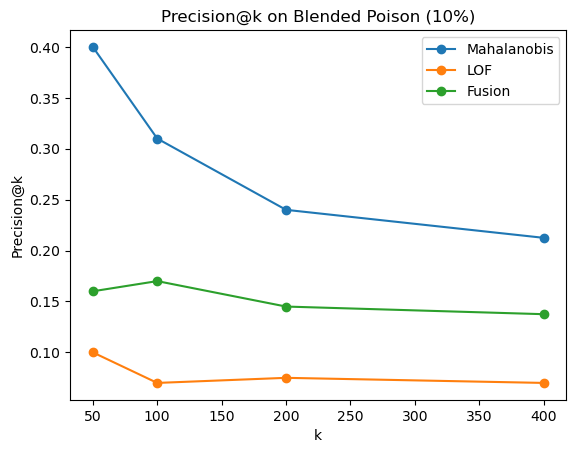

In [15]:

def precision_at_k(order_indices, ground_truth_set, k):
    return len(set(order_indices[:k]).intersection(ground_truth_set))/k

poisoned_set = set(poison_meta["indices"])
ks = [50, 100, 200, 400]

res = []
for k in ks:
    res.append({
        "k": k,
        "P@k_mahal": precision_at_k(I[order_m], poisoned_set, k),
        "P@k_lof":   precision_at_k(I[order_l], poisoned_set, k),
        "P@k_fuse":  precision_at_k(I[order_f], poisoned_set, k),
    })
print(json.dumps(res, indent=2))

# Quick plot
plt.figure()
plt.plot(ks, [r["P@k_mahal"] for r in res], marker='o', label='Mahalanobis')
plt.plot(ks, [r["P@k_lof"]   for r in res], marker='o', label='LOF')
plt.plot(ks, [r["P@k_fuse"]  for r in res], marker='o', label='Fusion')
plt.xlabel("k"); plt.ylabel("Precision@k"); plt.title("Precision@k on Blended Poison (10%)")
plt.legend(); plt.show()


## 9) Sanitize & retrain a student on cleaned data

In [27]:

def sanitize_indices(top_order_indices, k):
    return set(top_order_indices[:k])

def retrain_student_on_cleaned(k=200, epochs=10, batch_size=64, num_workers=0):
    removed = sanitize_indices(I[order_f], k)
    transform = tv.transforms.Compose([tv.transforms.ToTensor()])
    train = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    poisoned_set = set(poison_meta['indices'])
    target_class = poison_meta['target_class']

    class Cleaned(torch.utils.data.Dataset):
        def __len__(self): return len(train)
        def __getitem__(self, idx):
            x,y = train[idx]
            if idx in poisoned_set and idx in removed:
                return None  # skip this sample
            return x,y

    def collate_skipnone(batch):
        batch = [b for b in batch if b is not None]
        xs, ys = zip(*batch)
        return torch.stack(xs,0), torch.tensor(ys)

    ds = Cleaned()
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_skipnone)

    model = tv.models.resnet18(weights=None, num_classes=10).to(device)
    ce = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    sched = optim.lr_scheduler.MultiStepLR(opt, milestones=[5, 8], gamma=0.1)

    for epoch in range(epochs):
        model.train()
        total, correct, loss_sum = 0,0,0.0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x); loss = ce(logits,y)
            loss.backward(); opt.step()
            loss_sum += loss.item()*x.size(0)
            pred = logits.argmax(1); correct += (pred==y).sum().item(); total += x.size(0)
        sched.step()
        if (epoch+1)%5==0:
            print(f"[student epoch {epoch+1}] loss={loss_sum/total:.4f} acc={(correct/total)*100:.2f}%")
    return model

# Example (commented to save CPU time):
student = retrain_student_on_cleaned(k=200, epochs=10, batch_size=64, num_workers=0)
print("Student clean acc:", eval_clean_acc(student))
print("Student ASR:", eval_asr(student, target_class=poison_meta['target_class'], size=5, alpha=0.2))


[student epoch 5] loss=0.9485 acc=67.22%
[student epoch 10] loss=0.2573 acc=91.82%
Student clean acc: 0.7715
Student ASR: 0.1045


In [28]:
# ===== Summary (edit the numbers to your actual results) =====
summary = {
    "k_removed": 200,
    "clean_acc_before": float(clean_acc_poisoned),
    "asr_before": float(asr_poisoned),
    "clean_acc_after": float(eval_clean_acc(student)),
    "asr_after": float(eval_asr(student, target_class=poison_meta['target_class'], size=5, alpha=0.2)),
}
import json, os
os.makedirs("results", exist_ok=True)
with open("results/summary.json","w") as f: json.dump(summary, f, indent=2)
summary


{'k_removed': 200,
 'clean_acc_before': 0.5611,
 'asr_before': 0.8806,
 'clean_acc_after': 0.7715,
 'asr_after': 0.1045}

In [ ]:
def sweep_k_and_measure(ks=(50,100,200,400), epochs=6):
    rows = []
    for k in ks:
        print(f"== k={k}")
        student_k = retrain_student_on_cleaned(k=k, epochs=epochs, batch_size=64, num_workers=0)
        row = {
            "k": k,
            "P@k_fuse": precision_at_k(I[order_f], set(poison_meta["indices"]), k),
            "clean_acc_after": float(eval_clean_acc(student_k)),
            "asr_after": float(eval_asr(student_k, target_class=poison_meta['target_class'], size=5, alpha=0.2)),
        }
        rows.append(row)
    return rows

# (This takes time on CPU; you can start with epochs=4 for a quick look)
grid = sweep_k_and_measure(ks=(50,100,200,400), epochs=4)
grid


In [ ]:
import matplotlib.pyplot as plt
ks = [r["k"] for r in grid]
asr = [r["asr_after"] for r in grid]
acc = [r["clean_acc_after"] for r in grid]
plt.plot(ks, asr, marker='o', label='ASR after sanitize'); 
plt.plot(ks, acc, marker='o', label='Clean Acc after sanitize'); 
plt.xlabel("k removed"); plt.title("Sanitization effect vs k"); plt.legend(); plt.show()
